In [1]:
from __future__ import annotations

from collections import defaultdict
from collections.abc import Iterable, Generator

from simpy.resources.resource import Request, Release

import matplotlib.pyplot as plt
import random
import simpy
import statistics

In [2]:
class Customer:
    def __init__(self, env: simpy.Environment, bank: Bank, arrival_time: float, service_time: float) -> None:
        self.env = env
        self.bank = bank
        self.arrival_time: float = arrival_time
        self.service_time: float = service_time
       
        self.delay: float | None = None

    def main(self):

        # Request the cashier
        with self.bank.cashier.request() as request:
            
            # Record the time the customer joined the queue
            queue_entry_time = self.env.now
            
            # Wait for the cashier to become available
            yield request

            # Record the time the customer left the queue
            queue_exit_time = self.env.now
            
            # Calculate the time the customer spent waiting in the queue
            self.delay = queue_exit_time - queue_entry_time

            # Wait for the cashier to process the customer
            yield self.env.process(self.bank.cashier.process_customer(self))


In [3]:
class Cashier(simpy.Resource):
    def __init__(self, env: simpy.Environment, capacity: int) -> None:
        super().__init__(env, capacity)
        self.env = env
        self.queue_history: dict[int, float] = defaultdict(float)
        self.qt: list[tuple[float, int]] = []
        self.ut: list[tuple[float, int]] = [(0, 0)]
        
        self.last_queue_level: int = 0
        self.last_queue_level_timestamp: float = 0
        
        self.worked_time: float = 0
    
    @property
    def average_queue_length(self) -> float:
        return sum(queue_length * time for queue_length, time in self.queue_history.items()) / self.env.now
    
    @property
    def utilization_rate(self) -> float:
        return self.worked_time / self.env.now
    
    def _update_qt(self) -> None:
        self.qt.append((self.env.now, len(self.queue)))
    
    def _update_ut(self) -> None:
        status = int(self.count == 1 or len(self.queue) > 0)
        if self.ut and self.ut[-1][1] == status:
            return
        self.ut.append((self.env.now, status))
    
    def _update_queue_history(self, _) -> None:
        self.queue_history[self.last_queue_level] += self.env.now - self.last_queue_level_timestamp
        self.last_queue_level_timestamp = self.env.now
        self.last_queue_level = len(self.queue)
        self._update_qt()
    
    def request(self) -> Request:
        request = super().request()
        self._update_queue_history(None)
        
        request.callbacks.append(self._update_queue_history)
        return request
    
    def release(self, request: Request) -> Release:
        release = super().release(request)
        self._update_ut()
        return release
    
    def process_customer(self, customer: Customer) -> Generator[simpy.Event, None, None]:
        yield self.env.timeout(customer.service_time)
        self.worked_time += customer.service_time
        
    def plot_qt(self) -> None:
        x, y = zip(*self.qt)
        plt.step(x, y, where='pre')
        plt.fill_between(x, y, step='pre', alpha=1.0)
        plt.title('Q(t): Queue length over time')
        plt.xlabel('Simulation Time')
        plt.ylabel('Queue Length')
        plt.show()
    
    def plot_ut(self) -> None:
        ut = self.ut + [(self.env.now, self.ut[-1][1])]
        x, y = zip(*ut)
        plt.step(x, y, where='post')
        plt.fill_between(x, y, step='post', alpha=1.0)
        plt.title('U(t): Cashier utilization over time')
        plt.xlabel('Simulation Time')
        plt.ylabel('Utilization rate')
        plt.show()


In [4]:
class Bank:
    def __init__(self, env: simpy.Environment, customer_arrival_rate: float, customer_average_processing_time: float) -> None:
        self.env = env
        self.cashier = Cashier(env, capacity=1)
        self.customer_arrival_rate = customer_arrival_rate                          # [customers/minute]
        self.customer_average_processing_time = customer_average_processing_time    # [minutes/customer]
        
        self.customers_inter_arrival_times: list[float] = []
        self.customers: list[Customer] = []
    
    @property
    def customer_service_times(self) -> Iterable[float]:
        for customer in self.customers:
            yield customer.service_time
    
    @property
    def customer_delay_times(self) -> Iterable[float]:
        for customer in self.customers:
            if customer.delay is not None:
                yield customer.delay
    
    def run(self):
        while True:
            
            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average delta time from one customer to the next (in minutes)
            customer_inter_arrival_time = random.expovariate(lambd=self.customer_arrival_rate)
            self.customers_inter_arrival_times.append(customer_inter_arrival_time)
            
            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average processing time for a customer (in minutes)
            customer_service_time = random.expovariate(1/self.customer_average_processing_time)
            
            # Wait for the next customer to arrive
            yield self.env.timeout(customer_inter_arrival_time)
            
            # Generate a new customer
            customer = Customer(
                env=self.env,
                bank=self,
                arrival_time=self.env.now,
                service_time=customer_service_time
            )
            self.customers.append(customer)
            
            self.env.process(customer.main())


In [5]:
seed = 42
random.seed(seed)

env = simpy.Environment()
bank = Bank(
    env, 
    customer_arrival_rate=4,                # n customers/minute        -->     1/n minutes/customer
    customer_average_processing_time=1/5    # 1/n minutes/customer      -->     n customers/minute
)
env.process(bank.run())
env.run(until=60 * 24 * 10)  # minutes

## Average inter-arrival time E[1/λ]

Average Customer Inter-arrival time = 0.25 minutes


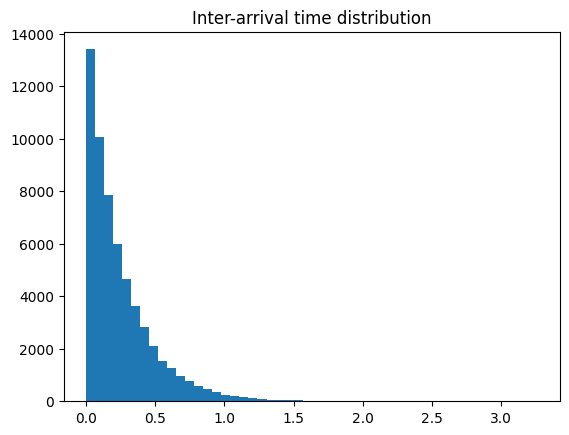

In [6]:
average_customer_inter_arrival_time = statistics.mean(bank.customers_inter_arrival_times)
print(f"Average Customer Inter-arrival time = {average_customer_inter_arrival_time:.2f} minutes")
plt.hist(bank.customers_inter_arrival_times, bins=50)
plt.title('Inter-arrival time distribution')
plt.show()

## Average service time E[S]

Average Customer service time = 0.20 minutes


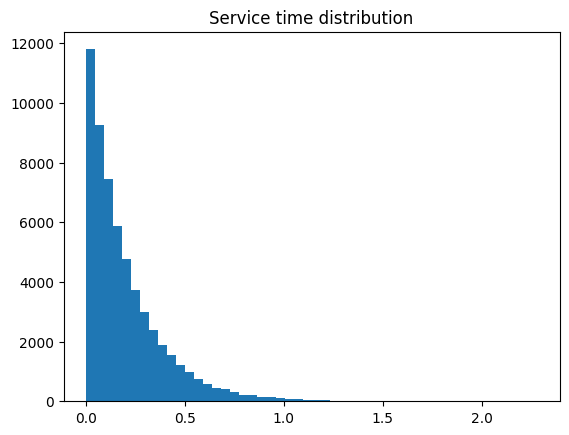

In [7]:
average_customer_service_time = statistics.mean(bank.customer_service_times)
print(f"Average Customer service time = {average_customer_service_time:.2f} minutes")
plt.hist(list(bank.customer_service_times), bins=50)
plt.title('Service time distribution')
plt.show()

## Average delay time E[D]

Average Customer delay time = 0.83 minutes


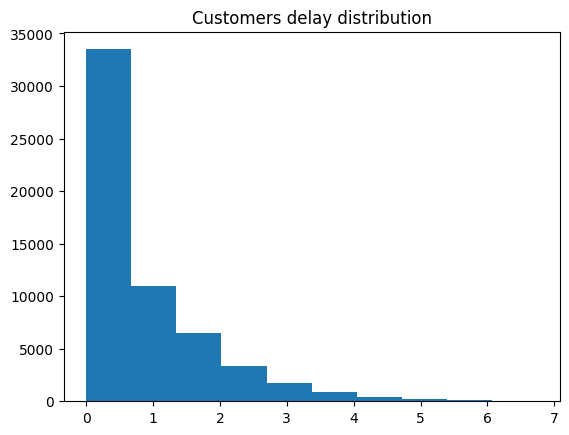

In [8]:
average_customer_delay_time = statistics.mean(bank.customer_delay_times)
print(f"Average Customer delay time = {average_customer_delay_time:.2f} minutes")
plt.hist(list(bank.customer_delay_times), bins=10)
plt.title('Customers delay distribution')
plt.show()

## Average number of customers in the queue E[Q]

Average Cashier queue length = 3.30


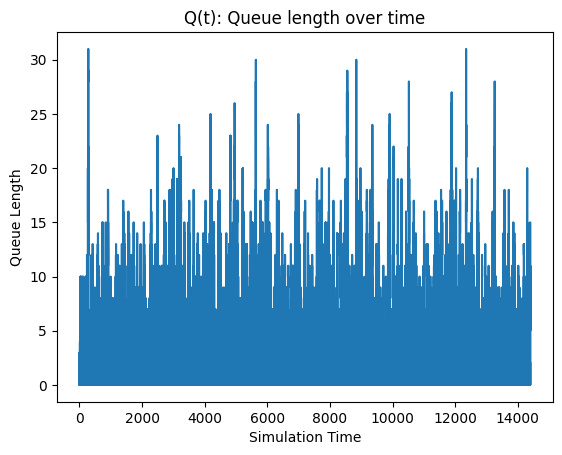

In [9]:
average_cashier_queue_length = bank.cashier.average_queue_length
print(f"Average Cashier queue length = {average_cashier_queue_length:.2f}")
bank.cashier.plot_qt()

## Server utilization rate E[U]

Average Server Utilization rate = 80.20%


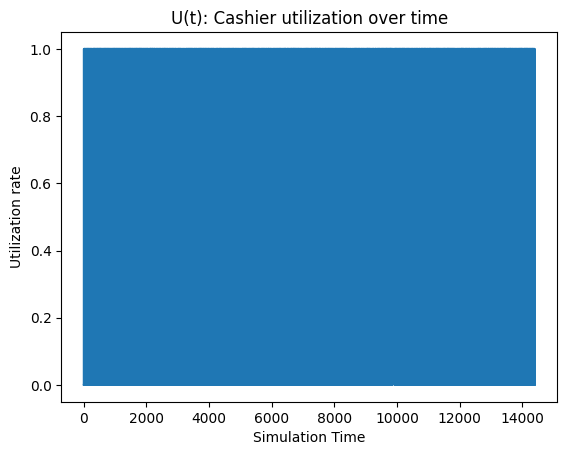

In [10]:
average_utilization_rate = bank.cashier.utilization_rate
print(f"Average Server Utilization rate = {average_utilization_rate * 100:.2f}%")
bank.cashier.plot_ut()

In [14]:
random.seed(None)

results = []
for _ in range(150):
    env = simpy.Environment()
    bank = Bank(
        env, 
        customer_arrival_rate=4,              # n customers/minute        -->     1/n minutes/customer
        customer_average_processing_time=1/5    # 1/n minutes/customer      -->     n customers/minute
    )
    env.process(bank.run())
    env.run(until=60 * 24 * 10)  # minutes
    results.append(bank.cashier.average_queue_length)

In [15]:
m = statistics.mean(results)
s = statistics.stdev(results)

moe = 1.96 * s / len(results) ** 0.5

print(f"Average Cashier queue length = {m:.2f} ± {moe:.2f}")

Average Cashier queue length = 3.19 ± 0.03


In [16]:
ro = 0.8
true_average_queue_length = ro ** 2 / (1 - ro)
print(f"Average Queue Length = {true_average_queue_length:.2f}")
m - moe <= true_average_queue_length <= m + moe

Average Queue Length = 3.20


True

## Banking System with Jockeying

Implement a banking queue system with multiple tellers (start with 5 servers) and jockeying.

Each teller has a separate queue.

An arriving customer joins the shortest queue, choosing the leftmost shortest queue in case of ties.

Let n_i be the total number of customers in front of teller i (including customers in queue as well as the customer in service, if any) at a particular instant. 

If the completion of a customer’s service at teller i causes n_j > n_i + 1 for some other teller j, then the customer from the tail of queue j jockeys (moves) to the tail of queue i.

Assume:
  - Interarrival times of customers are exponentially distributed with a mean of 1 minute.
  - Service times are exponentially distributed with a mean of 4.5 minutes.

Measure system performance for systems with 4, 5, 6, and 7 tellers.

## Banking System with Impatient Customers

Implement a banking queue system with single teller and impatient customers.

Customers arrive at the bank at an average rate of 5 per minute and are served by a single teller whose service times are exponentially distributed with a mean of 6 minutes.

If a customer finds the teller busy, they wait in the queue. However, if the customer waits for more than 10 minutes and the teller is still busy, the customer leaves the bank.

Simulate the system and measure the following performance measures:
  - Average number of customers in the queue
  - Average number of customers who leave the bank without being served